# Lightcurve Dataframe Visualization with and without ML

In [2]:
import sys
import os
import re
import time
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd

sys.path.append('code/')
from data_structures import MultiIndexDFObject
from utils import *

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]

plt.style.use('bmh')

#!pip install -r requirements.txt
#!python sample_lc.py

In [3]:
# load a previously saved file 
parquet_loadname = 'data/df_lc_.parquet.gzip'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)


## What is in this sample?

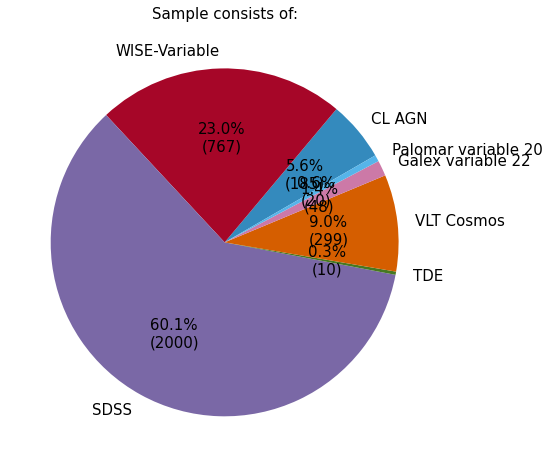

In [4]:
from collections import Counter
numobj = len(parallel_df_lc.data.index.get_level_values('objectid')[:].unique())
seen = Counter()
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    if label in cl_labels:
        label = ['CL AGN']
    if label=='ZTF-Objname':
        label= ['TDE']
    if label=='Cicco19':
        label= ['VLT Cosmos']
                
    seen.update(label)

plt.figure(figsize=(8,8))
plt.title(r'Sample consists of:',size=15)
h = plt.pie(seen.values(),labels=seen.keys(),autopct=autopct_format(seen.values()), textprops={'fontsize': 15},startangle=30,  labeldistance=1.1)

Text(0, 0.5, '#')

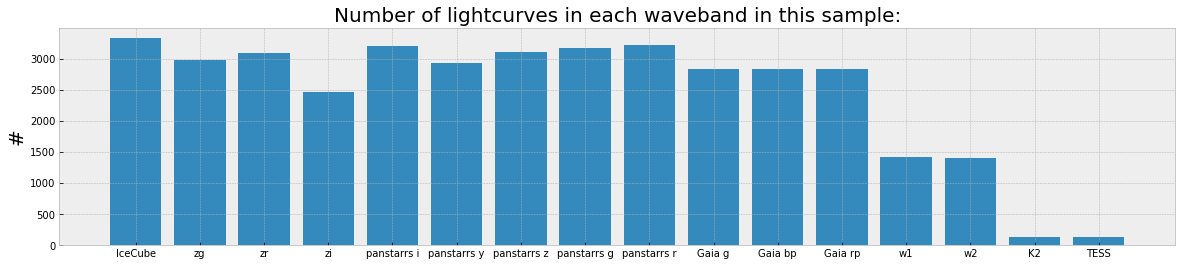

In [5]:
seen = Counter()
for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bands = singleobj.loc[b,label[0],:,:].index.get_level_values('band')[:].unique()
    seen.update(bands)

plt.figure(figsize=(20,4))
plt.title(r'Number of lightcurves in each waveband in this sample:',size=20)
h = plt.bar(seen.keys(), seen.values())
plt.ylabel(r'#',size=20)

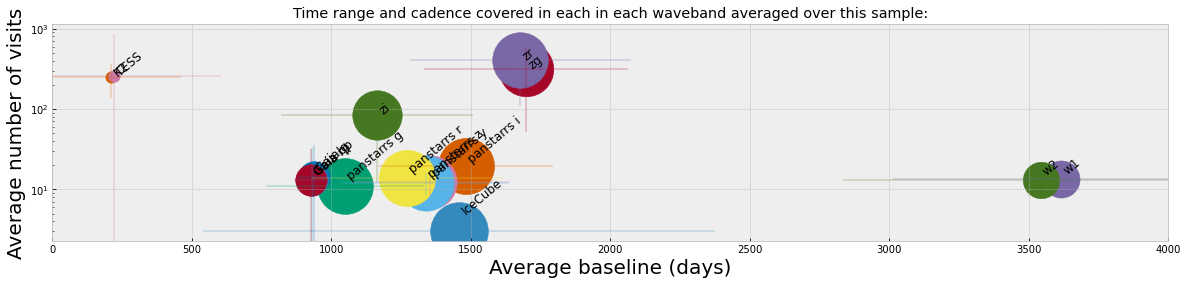

In [6]:
cadence = dict((el,[]) for el in seen.keys())
timerange = dict((el,[]) for el in seen.keys())

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bband = singleobj.index.unique('band')
    for bb in bband:
        bands = singleobj.loc[b,label[0],bb,:].index.get_level_values('time')[:]
        #bands.values
        #print(bb,len(bands[:]),np.round(bands[:].max()-bands[:].min(),1))    
        cadence[bb].append(len(bands[:]))
        if bands[:].max()-bands[:].min()>0:
            timerange[bb].append(np.round(bands[:].max()-bands[:].min(),1))    

plt.figure(figsize=(20,4))
plt.title(r'Time range and cadence covered in each in each waveband averaged over this sample:')
for el in cadence.keys():
    #print(el,len(cadence[el]),np.mean(cadence[el]),np.std(cadence[el]))
    #print(el,len(timerange[el]),np.mean(timerange[el]),np.std(timerange[el]))
    plt.scatter(np.mean(timerange[el]),np.mean(cadence[el]),label=el,s=len(timerange[el]))
    plt.errorbar(np.mean(timerange[el]),np.mean(cadence[el]),xerr=np.std(timerange[el]),yerr=np.std(cadence[el]),alpha=0.2)
    plt.annotate(el,(np.mean(timerange[el]),np.mean(cadence[el])+2),size=12, rotation=40)
plt.ylabel(r'Average number of visits',size=20) 
plt.xlabel(r'Average baseline (days)',size=20) 
plt.xlim([0,4000])
plt.yscale('log')

## Starting with ZTF alone as it has the highest average number of visits
#### unifying the grid so different objects can be compared:

  0%|          | 0/3329 [00:00<?, ?it/s]

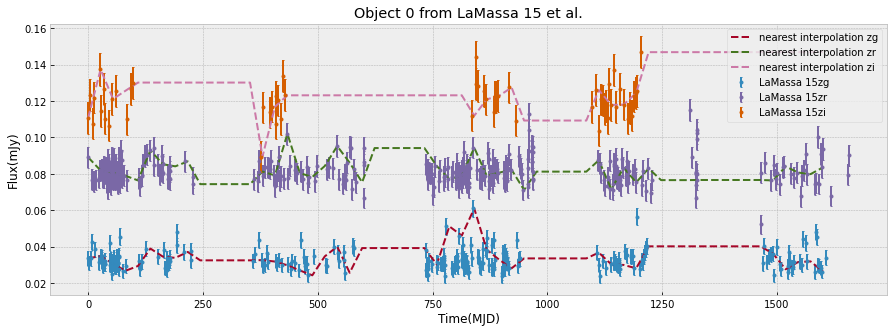

  0%|          | 1/3329 [00:00<26:46,  2.07it/s]

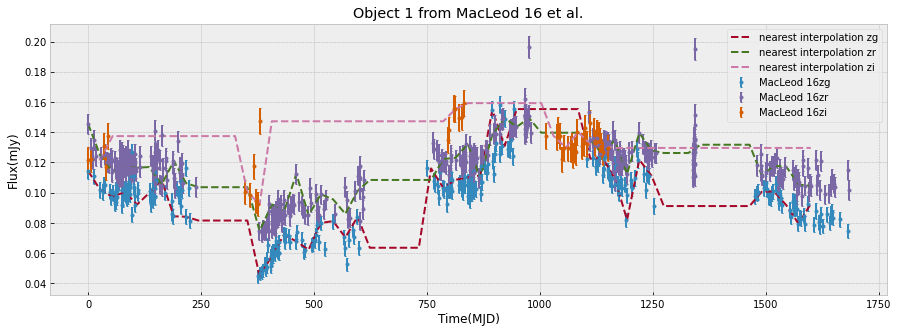

  0%|          | 2/3329 [00:00<26:05,  2.13it/s]

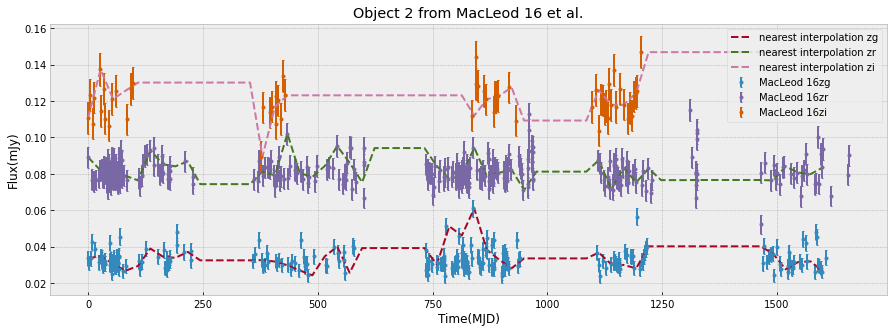

100%|██████████| 3329/3329 [02:38<00:00, 21.04it/s]


In [7]:
bands_inlc = ['zg','zr','zi']#,'panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=60,numplots=3)

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat_notnormal = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)

# Normalize the combinde array by mean brightness in a waveband after clipping outliers:
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

Text(0, 0.5, 'Normalized Flux (mean r band)')

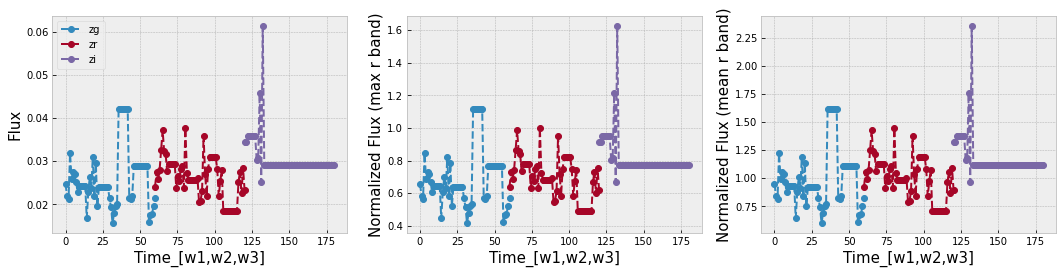

In [8]:
r = np.random.randint(np.shape(dat)[1])
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)

for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),dat_notnormal[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Flux',size=15)
plt.legend(loc=2)

plt.subplot(1,3,2)
for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),dat[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Normalized Flux (max r band)',size=15)

plt.subplot(1,3,3)
for i,l in enumerate(bands_inlc):
    s = int(np.shape(dat)[1]/len(bands_inlc))
    first = int(i*s)
    last = first+s
    plt.plot(np.linspace(first,last,s),datm[r,first:last],'o',linestyle='--',label=l)
plt.xlabel(r'Time_[w1,w2,w3]',size=15)
plt.ylabel(r'Normalized Flux (mean r band)',size=15)


(-4.680901074409485, 11.257295632362366, 1.703050446510315, 10.638760256767274)

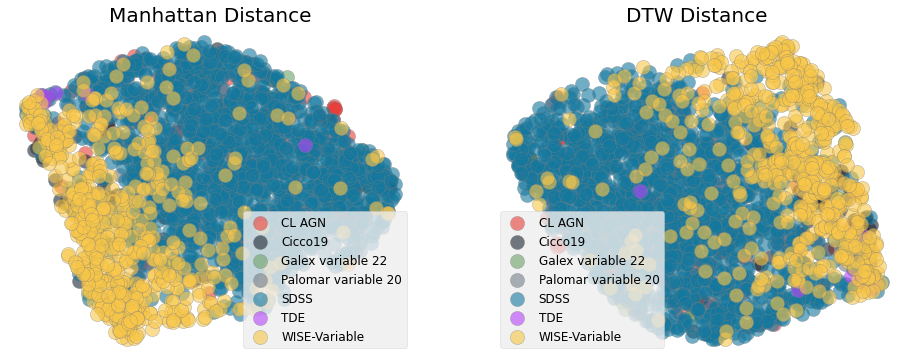

In [9]:
plt.figure(figsize=(16,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']


mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)
ax0 = plt.subplot(1,2,1)
ax0.set_title(r'Manhattan Distance',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')

mapperg = umap.UMAP(n_neighbors=50,min_dist=0.5,metric=dtw_distance,random_state=20).fit(data) #this distance takes long
ax2 = plt.subplot(1,2,2)
ax2.set_title(r'DTW Distance',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')

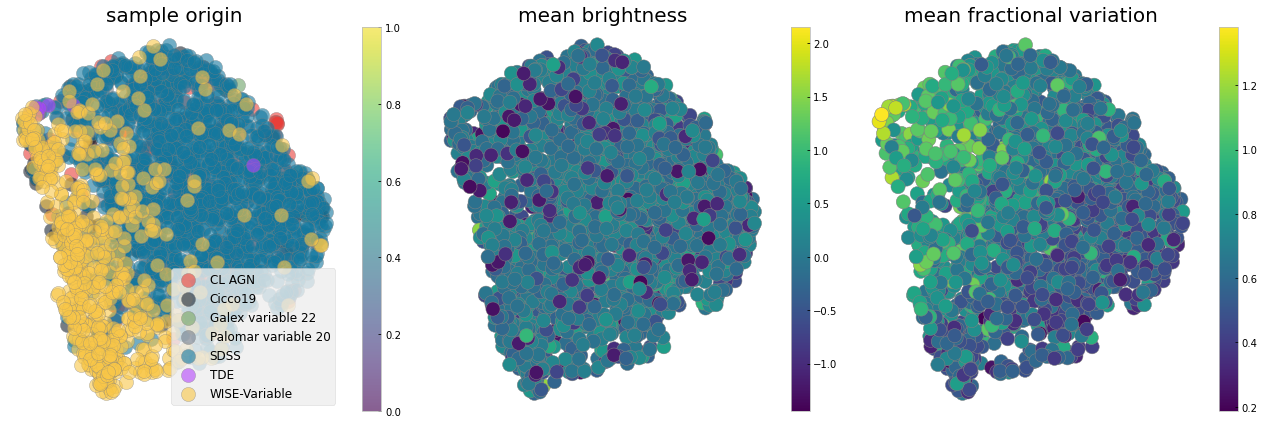

In [10]:
plt.figure(figsize=(18,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.sum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.sum(fvar_arr,axis=0),factor=3),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')

In [11]:
from sompy import * #using the SOMPY package from https://github.com/sevamoo/SOMPY
msz0,msz1 = 12,12
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.080000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.079000, quantization error: 8.418592

 epoch: 2 ---> elapsed time:  0.052000, quantization error: 8.123562

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 3

 epoch: 1 ---> elapsed time:  0.053000, quantization error: 7.375957

 epoch: 2 ---> elapsed time:  0.034000, quantization error: 7.176083

 epoch: 3 ---> elapsed time:  0.051000, quantization error: 7.116112

 Final quantization error: 7.076531
 train took: 0.489000 seconds


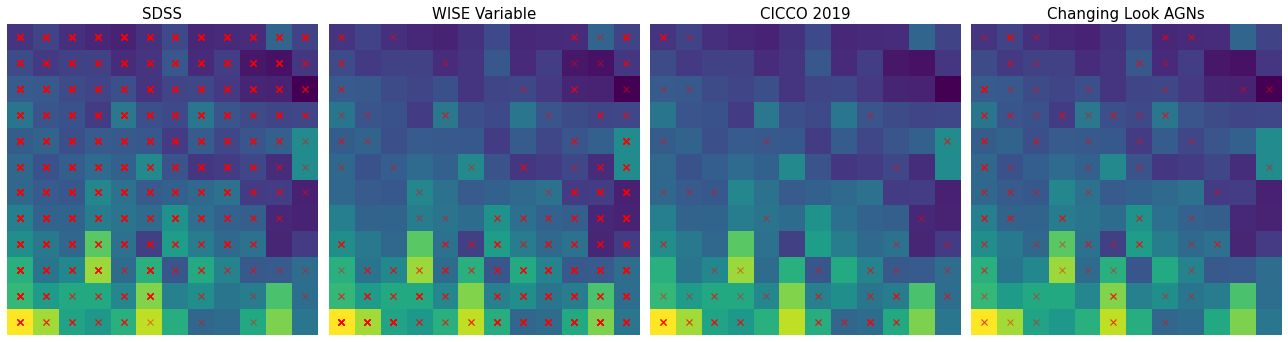

In [12]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1    
med_r=np.zeros([msz0,msz1])
fvar_new = stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=1)
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.nanmedian(fvar_new[unja]))
        

plt.figure(figsize=(18,8))
plt.subplot(1,4,1)
plt.title('SDSS',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')

d = []
for i,f in enumerate(fzr):
    if f=='SDSS':
        d.append(data[i,:])
dsdss =np.array(d)
asdss=sm.bmu_ind_to_xy(sm.project_data(dsdss))                   
x,y=np.zeros(len(asdss)),np.zeros(len(asdss))
k=0
for i in asdss:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,2)
plt.title('WISE Variable',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='WISE-Variable':
        d.append(data[i,:])
dwise =np.array(d)
awise=sm.bmu_ind_to_xy(sm.project_data(dwise))                   
x,y=np.zeros(len(awise)),np.zeros(len(awise))
k=0
for i in awise:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,3)
plt.title('CICCO 2019',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='Cicco19':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)


plt.subplot(1,4,4)
plt.title('Changing Look AGNs',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='CL AGN':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.tight_layout()

The above SOMs are colored by the mean fractional variation of the lightcurves in all bands (a measure of AGN variability). The crosses are different samples mapped to the trained SOM to see if they are distinguishable on a normalized lightcurve som.

In [13]:
# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat_notnormal,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'       
sm = sompy.SOMFactory.build(data, mapsize=[10,10], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.066000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.048000, quantization error: 16.255068

 epoch: 2 ---> elapsed time:  0.038000, quantization error: 1.462569

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.042000, quantization error: 1.067394

 epoch: 2 ---> elapsed time:  0.060000, quantization error: 1.000097

 Final quantization error: 0.967947
 train took: 0.386000 seconds


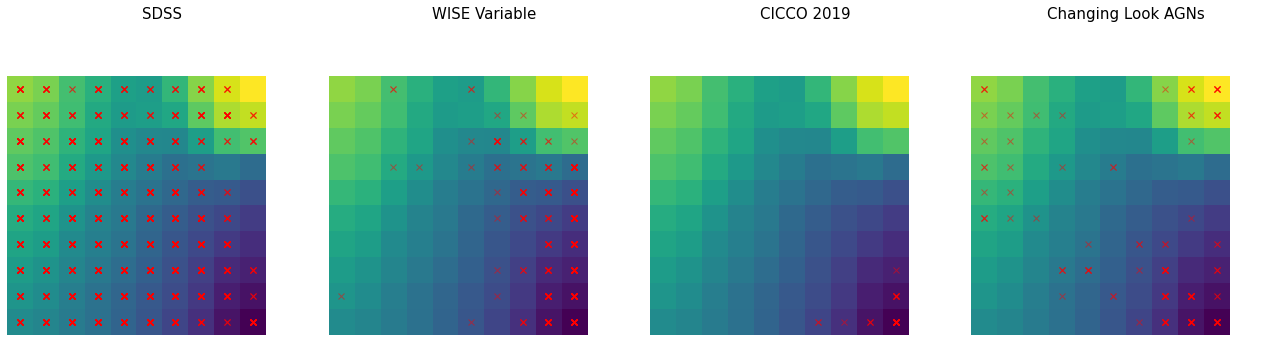

In [14]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1    
med_r=np.zeros([msz0,msz1])
fvar_new = stretch_small_values_arctan(np.nansum(maximum_arr,axis=0),factor=0.5)
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.nanmedian(fvar_new[unja]))
        

plt.figure(figsize=(18,8))
plt.subplot(1,4,1)
plt.title(r'SDSS',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')

d = []
for i,f in enumerate(fzr):
    if f=='SDSS':
        d.append(data[i,:])
dsdss =np.array(d)
asdss=sm.bmu_ind_to_xy(sm.project_data(dsdss))                   
x,y=np.zeros(len(asdss)),np.zeros(len(asdss))
k=0
for i in asdss:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,2)
plt.title(r'WISE Variable',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='WISE-Variable':
        d.append(data[i,:])
dwise =np.array(d)
awise=sm.bmu_ind_to_xy(sm.project_data(dwise))                   
x,y=np.zeros(len(awise)),np.zeros(len(awise))
k=0
for i in awise:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,3)
plt.title(r'CICCO 2019',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='Cicco19':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)


plt.subplot(1,4,4)
plt.title(r'Changing Look AGNs',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='CL AGN':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.tight_layout()

skipping the normalization of lightcurves, can show for example how the Cicco et al. 2019 sample, from the 3year VLT observations of the COSMOS field are all fainter compared to the rest.

## Now looking at Panstarrs alone (smaller number of visits)

  0%|          | 0/3329 [00:00<?, ?it/s]

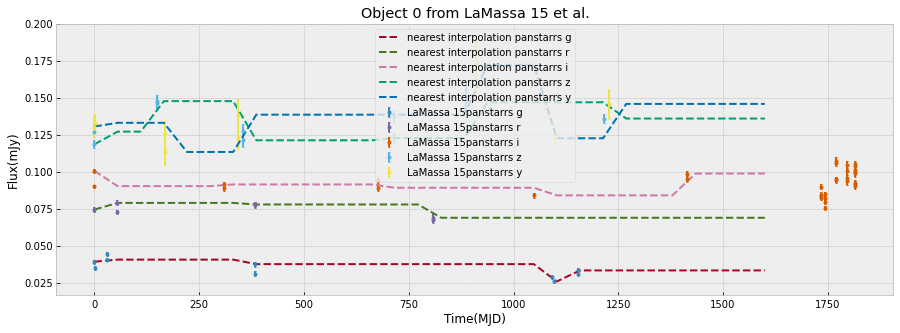

  0%|          | 1/3329 [00:00<32:57,  1.68it/s]

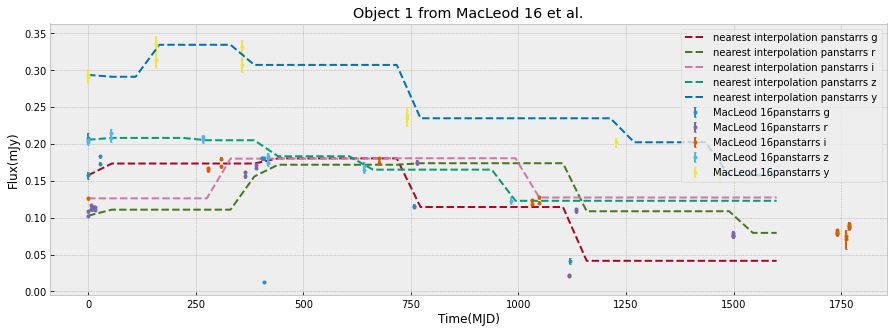

  0%|          | 2/3329 [00:01<33:36,  1.65it/s]

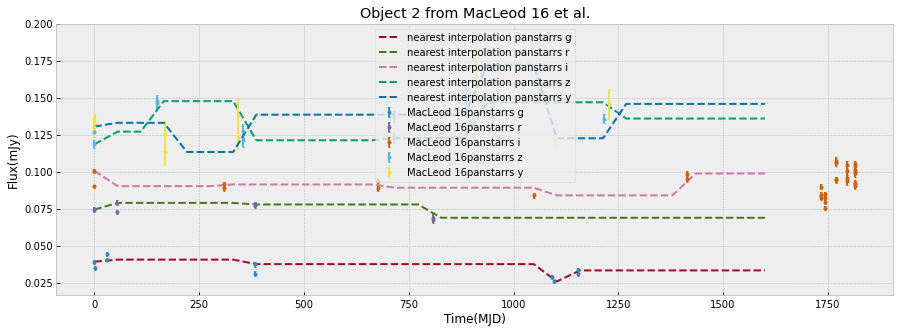

100%|██████████| 3329/3329 [03:13<00:00, 17.16it/s]


In [15]:
bands_inlc = ['panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30,numplots=3)

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat_notnormal = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)

# Normalize the combinde array by mean brightness in a waveband after clipping outliers:
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

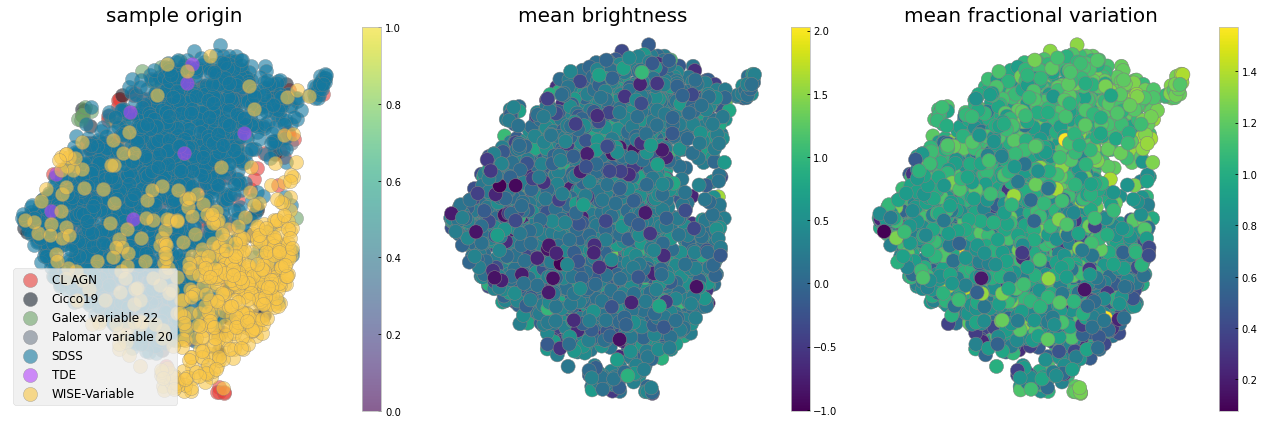

In [16]:
plt.figure(figsize=(18,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr,axis=0),factor=2),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')

 Training...
 pca_linear_initialization took: 0.045000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 2

 epoch: 1 ---> elapsed time:  0.051000, quantization error: 7.214503

 epoch: 2 ---> elapsed time:  0.051000, quantization error: 6.901523

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 3

 epoch: 1 ---> elapsed time:  0.044000, quantization error: 6.645304

 epoch: 2 ---> elapsed time:  0.059000, quantization error: 6.446556

 epoch: 3 ---> elapsed time:  0.049000, quantization error: 6.314025

 Final quantization error: 6.260099
 train took: 0.465000 seconds


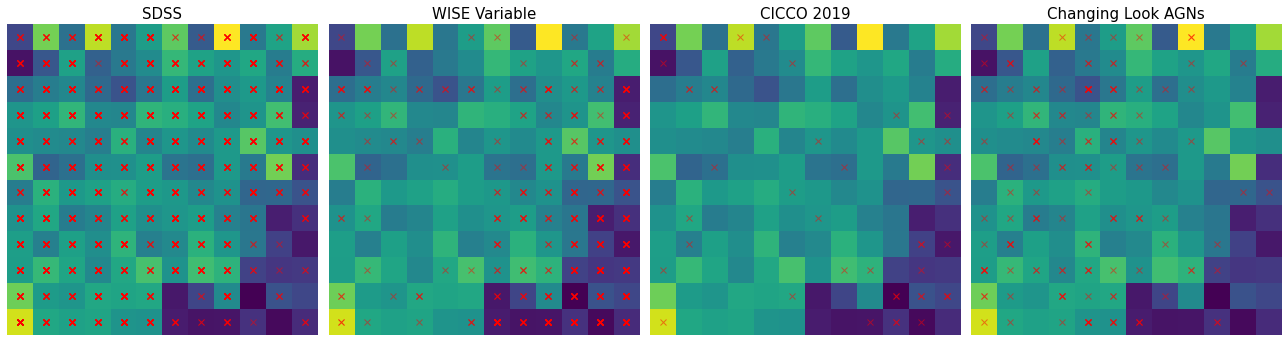

In [17]:
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1    
med_r=np.zeros([msz0,msz1])
fvar_new = stretch_small_values_arctan(np.nansum(maximum_arr,axis=0),factor=0.5)
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_r[i,j]=(np.nanmedian(fvar_new[unja]))
        

plt.figure(figsize=(18,8))
plt.subplot(1,4,1)
plt.title(r'SDSS',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')

d = []
for i,f in enumerate(fzr):
    if f=='SDSS':
        d.append(data[i,:])
dsdss =np.array(d)
asdss=sm.bmu_ind_to_xy(sm.project_data(dsdss))                   
x,y=np.zeros(len(asdss)),np.zeros(len(asdss))
k=0
for i in asdss:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,2)
plt.title(r'WISE Variable',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='WISE-Variable':
        d.append(data[i,:])
dwise =np.array(d)
awise=sm.bmu_ind_to_xy(sm.project_data(dwise))                   
x,y=np.zeros(len(awise)),np.zeros(len(awise))
k=0
for i in awise:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.subplot(1,4,3)
plt.title(r'CICCO 2019',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='Cicco19':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)


plt.subplot(1,4,4)
plt.title(r'Changing Look AGNs',fontsize=15)
cf=plt.imshow(med_r,origin='lower',cmap='viridis')
plt.axis('off')
d = []
for i,f in enumerate(fzr):
    if f=='CL AGN':
        d.append(data[i,:])
dcic =np.array(d)
acic=sm.bmu_ind_to_xy(sm.project_data(dcic))                   
x,y=np.zeros(len(acic)),np.zeros(len(acic))
k=0
for i in acic:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
plt.plot(y,x,'rx',alpha=0.5)

plt.tight_layout()

### ZTF With WISE

  0%|          | 0/3329 [00:00<?, ?it/s]

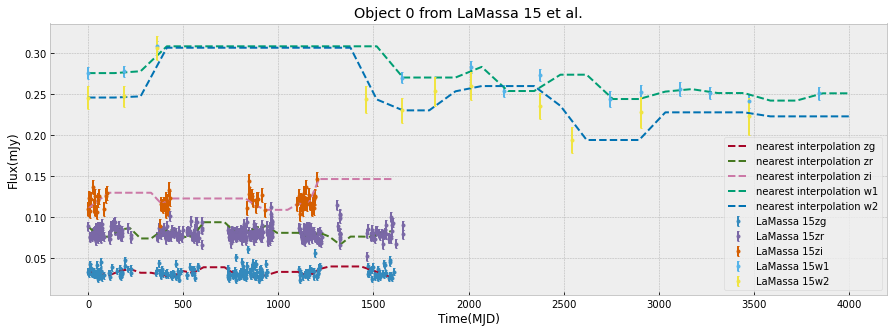

  0%|          | 1/3329 [00:00<50:31,  1.10it/s]

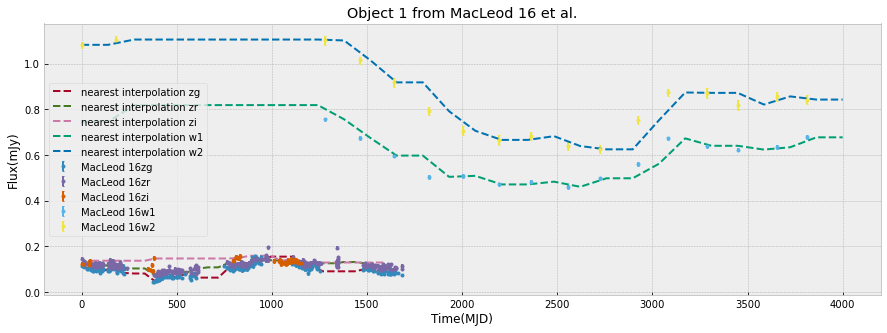

  0%|          | 2/3329 [00:01<45:46,  1.21it/s]

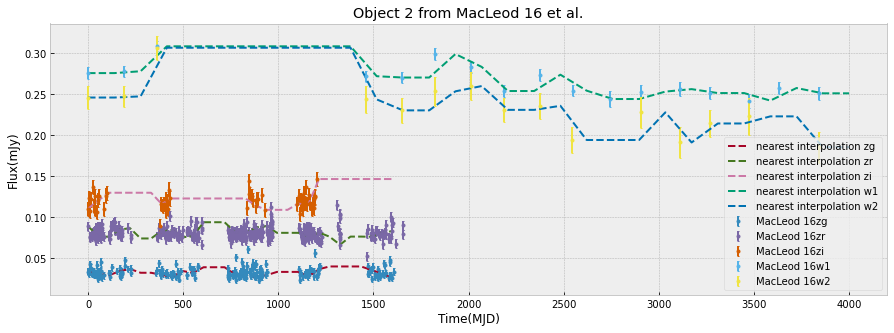

100%|██████████| 3329/3329 [02:30<00:00, 22.10it/s]


In [18]:
bands_inlc = ['zg','zr','zi','w1','w2']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30,numplots=3)
# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)
dat_notnormal = combine_bands(objects,bands_inlc)
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

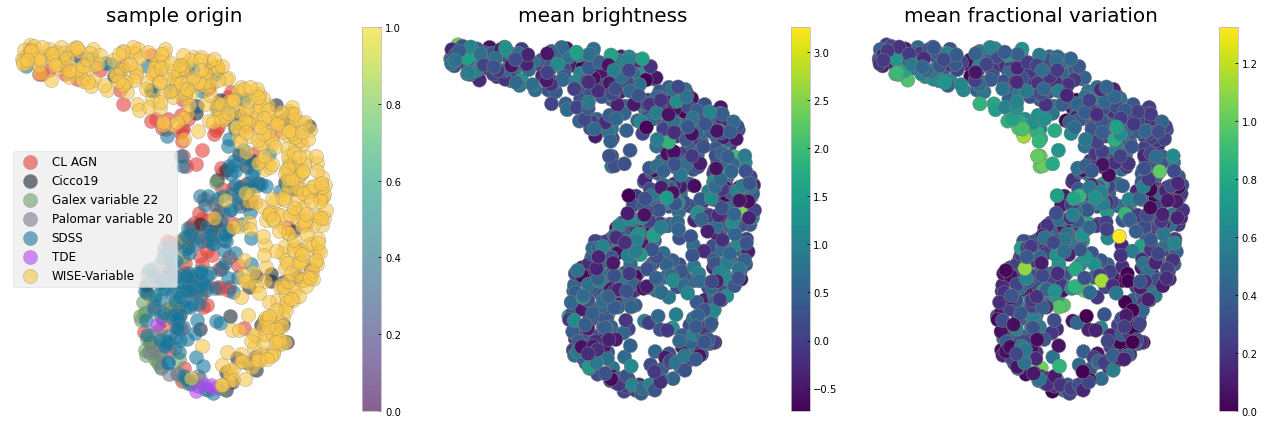

In [23]:
plt.figure(figsize=(18,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr[-2:-1,:],axis=0),factor=4),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')

### Wise only

  0%|          | 0/3329 [00:00<?, ?it/s]

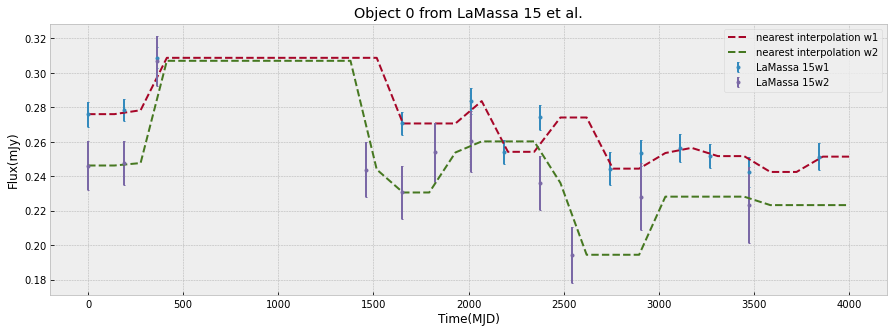

  0%|          | 1/3329 [00:00<20:04,  2.76it/s]

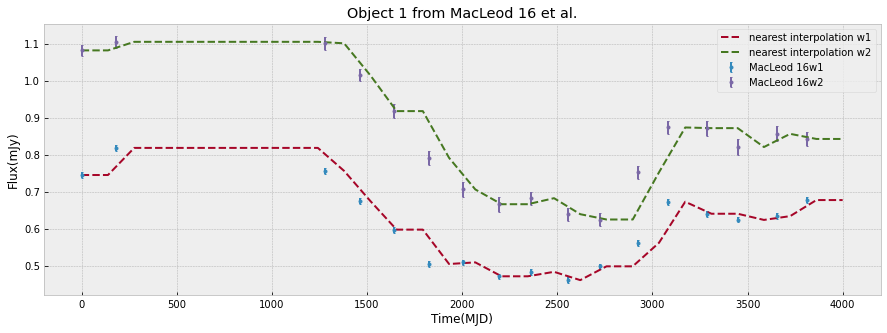

  0%|          | 2/3329 [00:00<20:07,  2.76it/s]

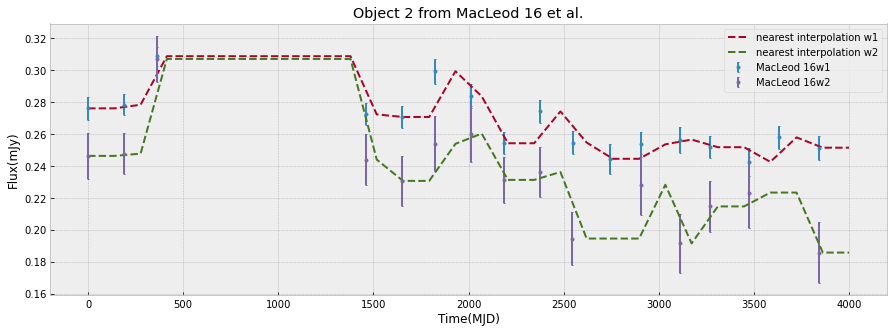

100%|██████████| 3329/3329 [02:19<00:00, 23.90it/s]


In [24]:
bands_inlc = ['w1','w2']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=30,numplots=3)
# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)
dat_notnormal = combine_bands(objects,bands_inlc)
dat = normalize_clipmax_objects(dat_notnormal,maxarray,band = 1)
datm = normalize_clipmax_objects(dat_notnormal,meanarray,band = 1)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

In [ ]:
plt.figure(figsize=(18,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=200,min_dist=1,metric='manhattan',random_state=5).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.nansum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.nansum(fvar_arr[-2:-1,:],axis=0),factor=4),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')

(5.2691879034042355, 25.839040303230284, -9.725179839134217, 6.350171732902527)

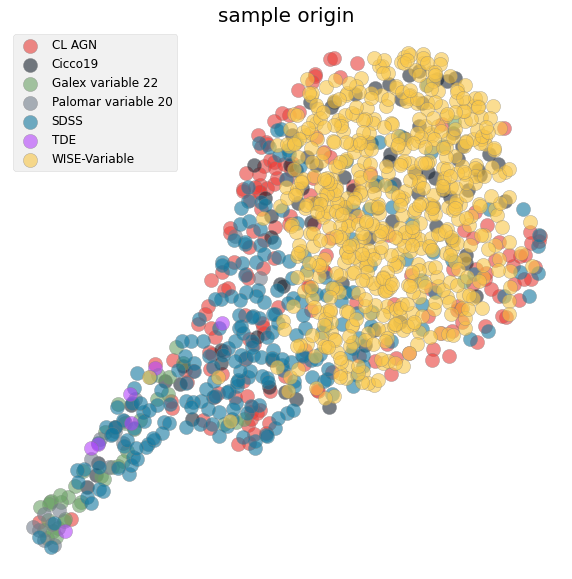

In [36]:
plt.figure(figsize=(10,10))
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=200,min_dist=1,metric='manhattan',random_state=5).fit(data)
ax2 = plt.subplot(1,1,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')